In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import KeyedVectors
import tensorflow as tf
from sklearn.model_selection import train_test_split

from string import punctuation
import nltk
#run this if you do not have nltk and follow the instructions
# nltk.download()
#run this if you already have nltk and define the path
nltk.data.path.append("/content/drive/My Drive/prepr challenge/nltk_data")

In [0]:
job_skills_data = pd.read_csv("/content/drive/My Drive/prepr challenge/job_skills.csv")

The data was obtained from statcan.gc.ca

Reference
Statistics Canada.  Table  14-10-0023-01   Labour force characteristics by industry, annual (x 1,000)

The following link will help generate the dataset.
https://www150.statcan.gc.ca/t1/tbl1/en/cv!recreate.action?pid=1410002301&selectedNodeIds=1D2,1D3,1D4,1D5,1D6,1D7,1D8,1D9,1D10,1D11,5D2,5D3,5D4&checkedLevels=1D2,2D1,2D2,2D3,2D4,3D2&refPeriods=20150101,20190101&dimensionLayouts=layout3,layout3,layout3,layout3,layout3,layout2&vectorDisplay=false

In [0]:
employment_data = pd.read_csv("/content/drive/My Drive/prepr challenge/1410002301_databaseLoadingData.csv")

Lets visualize the employment data.

In [4]:
employment_data

,REF_DATE,GEO,DGUID,Labour force characteristics,North American Industry Classification System (NAICS),Sex,Age group,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2015,Newfoundland and Labrador,2016A000210,Employment,"Total, all industries",Males,15 to 24 years,Persons,249,thousands,3,v19669866,2.2.1.2.2,13.8,NaN,NaN,NaN,1
1,2016,Newfoundland and Labrador,2016A000210,Employment,"Total, all industries",Males,15 to 24 years,Persons,249,thousands,3,v19669866,2.2.1.2.2,14.3,NaN,NaN,NaN,1
2,2017,Newfoundland and Labrador,2016A000210,Employment,"Total, all industries",Males,15 to 24 years,Persons,249,thousands,3,v19669866,2.2.1.2.2,13.9,NaN,NaN,NaN,1
3,2018,Newfoundland and Labrador,2016A000210,Employment,"Total, all industries",Males,15 to 24 years,Persons,249,thousands,3,v19669866,2.2.1.2.2,13.2,NaN,NaN,NaN,1
4,2019,Newfoundland and Labrador,2016A000210,Employment,"Total, all industries",Males,15 to 24 years,Persons,249,thousands,3,v19669866,2.2.1.2.2,13.4,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17095,2015,British Columbia,2016A000259,Unemployment,Unclassified industries,Females,55 years and over,Persons,249,thousands,3,v19684649,11.5.29.3.4,4.0,NaN,NaN,NaN,1
17096,2016,British Columbia,2016A000259,Unemployment,Unclassified industries,Females,55 years and over,Persons,249,thousands,3,v19684649,11.5.29.3.4,5.6,NaN,NaN,NaN,1
17097,2017,British Columbia,2016A000259,Unemployment,Unclassified industries,Females,55 years and over,Persons,249,thousands,3,v19684649,11.5.29.3.4,5.5,NaN,NaN,NaN,1
17098,2018,British Columbia,2016A000259,Unemployment,Unclassified industries,Females,55 years and over,Persons,249,thousands,3,v19684649,11.5.29.3.4,3.5,NaN,NaN,NaN,1


There are 171,000 entries and 18 columns. This study will focus on Employment characteristics only and will ignore all Unemployment statistics.
It can be seen that many columns have empty values. First confirm which columns have empty entries and depending on that remove the appropriate ones.

In [5]:
employment_data = employment_data[employment_data["Labour force characteristics"] == "Employment"]
employment_data.isna().sum()

REF_DATE                                                    0
GEO                                                         0
DGUID                                                       0
Labour force characteristics                                0
North American Industry Classification System (NAICS)       0
Sex                                                         0
Age group                                                   0
UOM                                                         0
UOM_ID                                                      0
SCALAR_FACTOR                                               0
SCALAR_ID                                                   0
VECTOR                                                      0
COORDINATE                                                  0
VALUE                                                    1386
STATUS                                                   7014
SYMBOL                                                   8400
TERMINAT

As it can be seen that columns TERMINATED and SYMBOL have empty values for each entry. Also, the columns VECTOR, COORDINATE, STATUS and SYMBOL do not show any important significance and therefore can be removed. Since we already know that the data is represented per thousand, so we can remove the column SCALAR_FACTOR and instead multiply the VALUE column by 1000.

Also, lets simplify some of the column names.

In [0]:
employment_data = employment_data.drop(["TERMINATED", "SYMBOL", "VECTOR", "COORDINATE", "STATUS", "SCALAR_FACTOR"], axis=1)
employment_data["VALUE"] = employment_data["VALUE"].apply(lambda x: x*1000)

employment_data = employment_data.rename(columns={"North American Industry Classification System (NAICS)": "NAICD", "Labour force characteristics": "Employment Type", "REF_DATE": "DATE"})

In [7]:
employment_data

,DATE,GEO,DGUID,Employment Type,NAICD,Sex,Age group,UOM,UOM_ID,SCALAR_ID,VALUE,DECIMALS
0,2015,Newfoundland and Labrador,2016A000210,Employment,"Total, all industries",Males,15 to 24 years,Persons,249,3,13800.0,1
1,2016,Newfoundland and Labrador,2016A000210,Employment,"Total, all industries",Males,15 to 24 years,Persons,249,3,14300.0,1
2,2017,Newfoundland and Labrador,2016A000210,Employment,"Total, all industries",Males,15 to 24 years,Persons,249,3,13900.0,1
3,2018,Newfoundland and Labrador,2016A000210,Employment,"Total, all industries",Males,15 to 24 years,Persons,249,3,13200.0,1
4,2019,Newfoundland and Labrador,2016A000210,Employment,"Total, all industries",Males,15 to 24 years,Persons,249,3,13400.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16225,2015,British Columbia,2016A000259,Employment,Public administration [91],Females,55 years and over,Persons,249,3,8500.0,1
16226,2016,British Columbia,2016A000259,Employment,Public administration [91],Females,55 years and over,Persons,249,3,12000.0,1
16227,2017,British Columbia,2016A000259,Employment,Public administration [91],Females,55 years and over,Persons,249,3,10200.0,1
16228,2018,British Columbia,2016A000259,Employment,Public administration [91],Females,55 years and over,Persons,249,3,13900.0,1


Lets see what unique values do the columns DGUID, DECIMALS, UOM, UOM_ID and SCALAR_ID contain.

In [8]:
display(employment_data["UOM"].unique())
display(employment_data["UOM_ID"].unique())
display(employment_data["SCALAR_ID"].unique())
display(employment_data["DECIMALS"].unique())
display(employment_data["Employment Type"].unique())

array(['Persons'], dtype=object)

array([249])

array([3])

array([1])

array(['Employment'], dtype=object)

As we can see that these columns only contain a single type of value. This indicates that they will not provide any useful information for the model. Therefore, they can be removed.

In [0]:
employment_data = employment_data.drop(["UOM", "UOM_ID", "SCALAR_ID", "DECIMALS", "Employment Type"], axis=1)

In [10]:
employment_data

,DATE,GEO,DGUID,NAICD,Sex,Age group,VALUE
0,2015,Newfoundland and Labrador,2016A000210,"Total, all industries",Males,15 to 24 years,13800.0
1,2016,Newfoundland and Labrador,2016A000210,"Total, all industries",Males,15 to 24 years,14300.0
2,2017,Newfoundland and Labrador,2016A000210,"Total, all industries",Males,15 to 24 years,13900.0
3,2018,Newfoundland and Labrador,2016A000210,"Total, all industries",Males,15 to 24 years,13200.0
4,2019,Newfoundland and Labrador,2016A000210,"Total, all industries",Males,15 to 24 years,13400.0
...,...,...,...,...,...,...,...
16225,2015,British Columbia,2016A000259,Public administration [91],Females,55 years and over,8500.0
16226,2016,British Columbia,2016A000259,Public administration [91],Females,55 years and over,12000.0
16227,2017,British Columbia,2016A000259,Public administration [91],Females,55 years and over,10200.0
16228,2018,British Columbia,2016A000259,Public administration [91],Females,55 years and over,13900.0


In [11]:
display(employment_data["DGUID"].unique())
display(employment_data["GEO"].unique())
display(employment_data["NAICD"].unique())

array(['2016A000210', '2016A000211', '2016A000212', '2016A000213',
       '2016A000224', '2016A000235', '2016A000246', '2016A000247',
       '2016A000248', '2016A000259'], dtype=object)

array(['Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia',
       'New Brunswick', 'Quebec', 'Ontario', 'Manitoba', 'Saskatchewan',
       'Alberta', 'British Columbia'], dtype=object)

array(['Total, all industries', 'Goods-producing sector',
       'Agriculture [111-112, 1100, 1151-1152]',
       'Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100]',
       'Forestry and logging and support activities for forestry [113, 1153]',
       'Fishing, hunting and trapping [114]',
       'Mining, quarrying, and oil and gas extraction [21, 2100]',
       'Utilities [22]', 'Construction [23]', 'Manufacturing [31-33]',
       'Durables [321, 327, 331-339]', 'Non-durables [311-316, 322-326]',
       'Services-producing sector',
       'Wholesale and retail trade [41, 44-45]', 'Wholesale trade [41]',
       'Retail trade [44-45]', 'Transportation and warehousing [48-49]',
       'Finance, insurance, real estate, rental and leasing [52, 53]',
       'Finance and insurance [52]',
       'Real estate and rental and leasing [53]',
       'Professional, scientific and technical services [54]',
       'Business, building and other support services [55, 56]',
  

It looks as if DGUID is a province specific ID and will be usefull later to represent the provinces with an ID for the model's purpose. Also, simplfy the name for each industry.

In [0]:
employment_data["NAICD"] = employment_data["NAICD"].apply(lambda x: x.split("[")[0].strip())

Visualize the employment for each province for each year by age group.

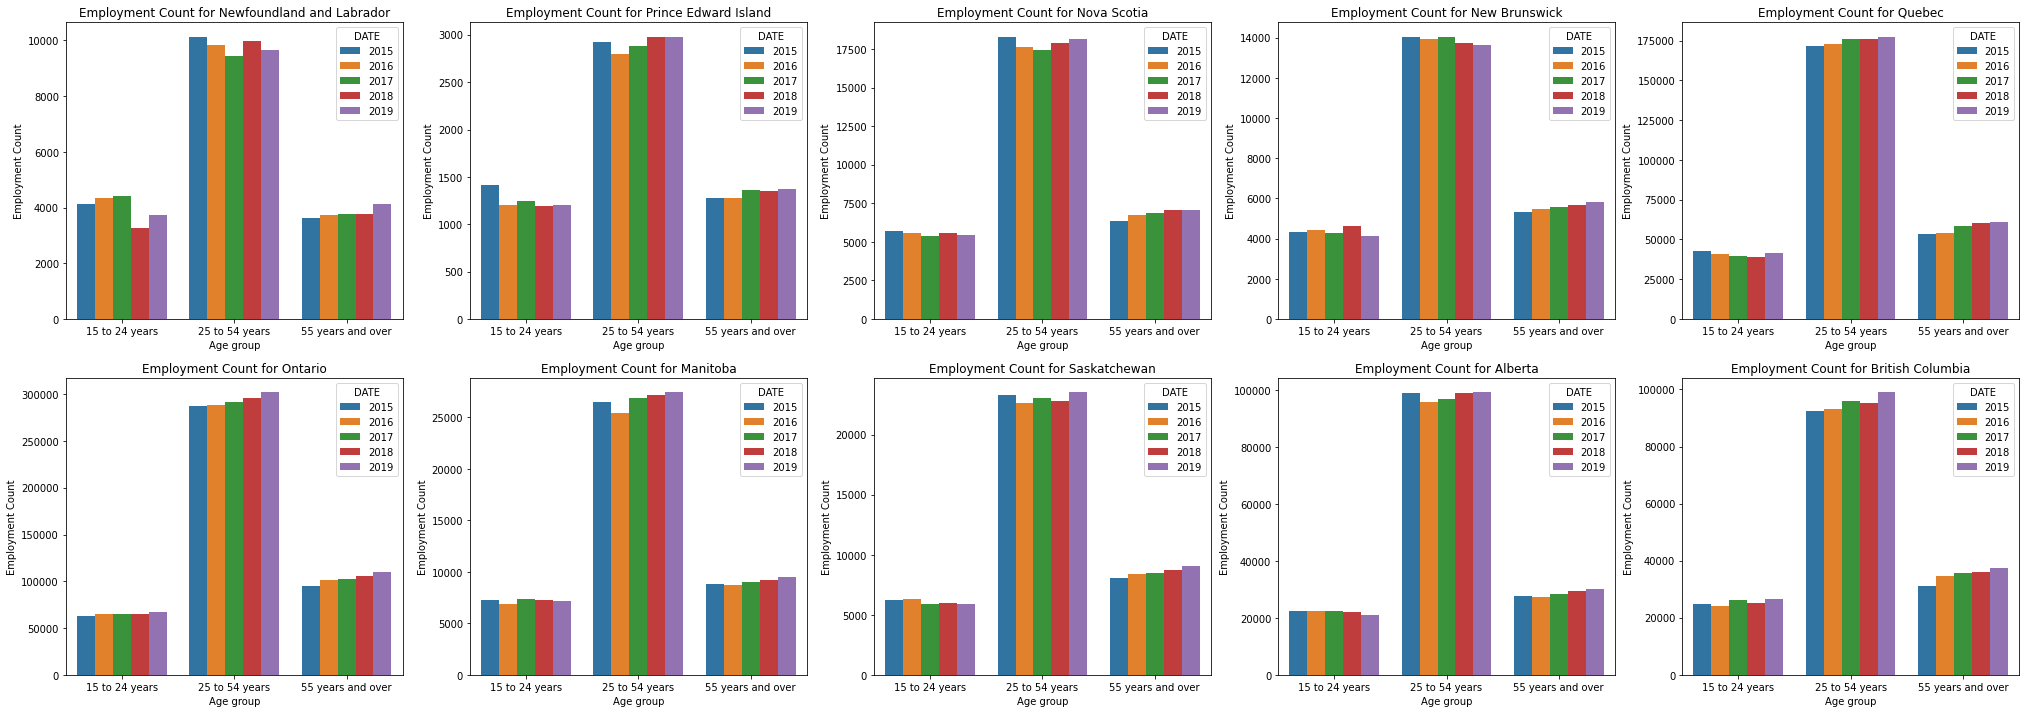

In [13]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(35, 12))

provinces = employment_data["GEO"].unique()
prov_count = 0
for i in range(0, 2):
  for j in range(0, 5):
    prov_data = employment_data[employment_data["GEO"] == provinces[prov_count]]
    sns.barplot(x="Age group", y="VALUE", hue="DATE", data=prov_data, ax=axes[i, j], ci=None)
    axes[i, j].set_ylabel("Employment Count")
    axes[i, j].set_title("Employment Count for " + provinces[prov_count])
    prov_count += 1

fig.show()

From the graph above, we can see that for each province the employment count falls majority in 25 to 54 years age group. The mostly followed by employment count falling in 55 years or more, and lastly 15 to 24 years age group contain the least number of employments across all provinces. It can also be seen that Newfoundland and Labrador has almost same or slightly higher employment count for 15-24 years age group, and 55 years and over. 

Another trend to be noticed is that for provinces such as Quebec, Ontario, Manitoba and British Columbia we can see a clear increase in employment count over the past 5 years for 25 to 54 years age group. But in New Brunswick, it is clear that employment count has decreased over the past 5 years for 25 to 54 years ago group. Saskatchewan shows an even trend over the past 5 years for 25 to 54 years age group.

For the 55 years and over age group, we can see that there is an overall increase in employment count for all provinces over the past 5 years.

Visualize the employment for each province for each year by sex.

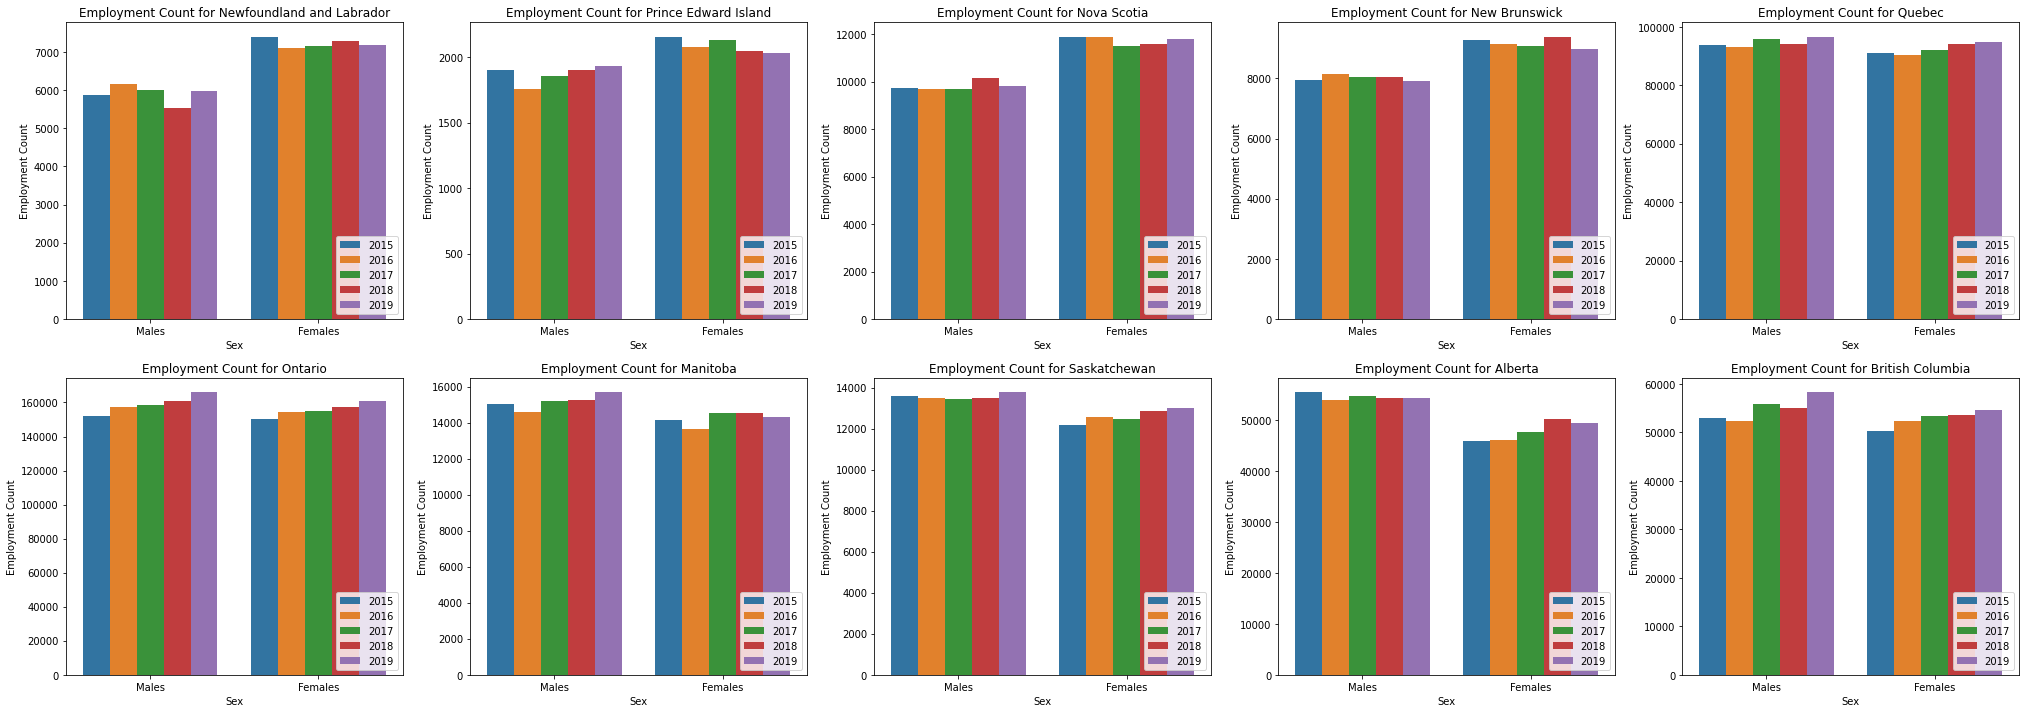

In [14]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(35, 12))

provinces = employment_data["GEO"].unique()
prov_count = 0
for i in range(0, 2):
  for j in range(0, 5):
    prov_data = employment_data[employment_data["GEO"] == provinces[prov_count]]
    sns.barplot(x="Sex", y="VALUE", hue="DATE", data=prov_data, ax=axes[i, j], ci=None)
    axes[i, j].legend(loc="lower right")
    axes[i, j].set_ylabel("Employment Count")
    axes[i, j].set_title("Employment Count for " + provinces[prov_count])
    prov_count += 1

fig.show()

Overall, it can be said all provinces have similar employment count for both sex. An interesting find is that provinces such as Newfoundland and Labrador, Nova Scotia and New Brunswick have higher female employment count than male. But provinces such as Alberta and Saskatchewan contain higher male employment count than female. 

It is somewhat clear from the graphs that the employment count for both sex has increased over the past 5 years for Quebec, Ontario and British Columbia. Alberta and Saskatchewan show a clear increase in female employment countover the past 5 years whereas Price Edward Island shows a decrease in female employment count over the past 5 years.

Lets visualize the top 5 most employed industry for each province and for each year.

In [0]:
#This function allows to obtain top 5 sectors for a province.
def get_province_top_5(data, province, top_count):
  province_top_5 = data[province].sort_values(ascending=False)[1:top_count+1]
  return pd.DataFrame({"province": province, "industry": province_top_5.index, "value": province_top_5})

#This function builds the DataFrame which includes top 5 industry sectors for each province 
# for a specific year.
def create_year_dataset(data, provinces):
  df = pd.DataFrame()
  empty = False

  for p in provinces:
    if empty:
      df = pd.concat([df, get_province_top_5(data, p, 5)], ignore_index=True)
    else:
      df = get_province_top_5(data, p, 5)
      empty = True

  return df.sort_values("value", ascending=False)

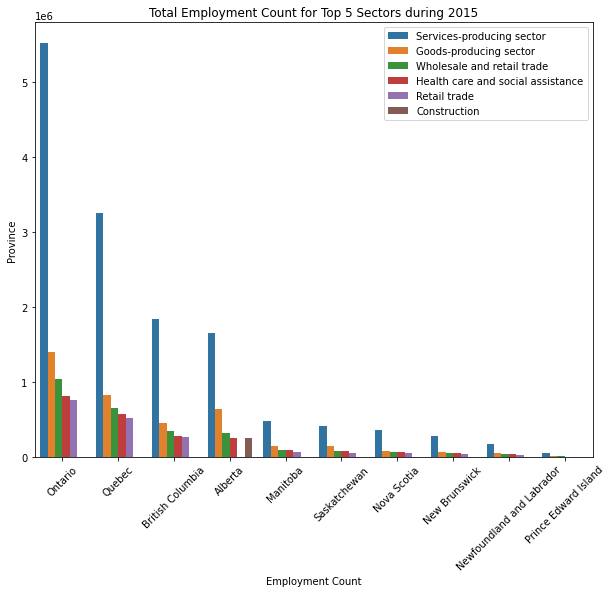

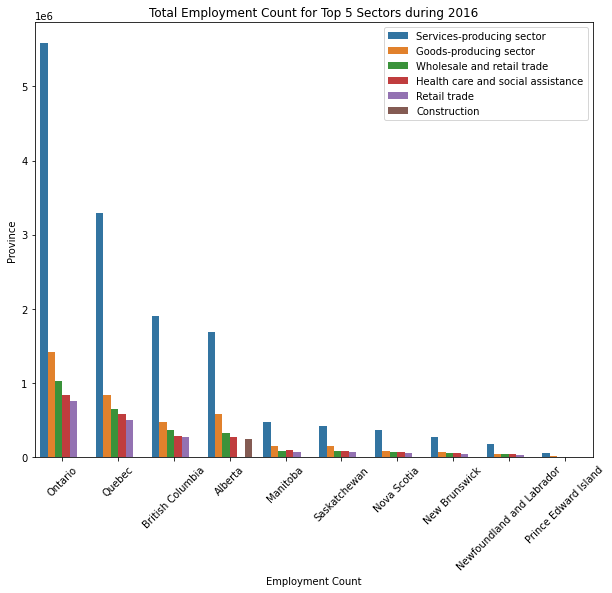

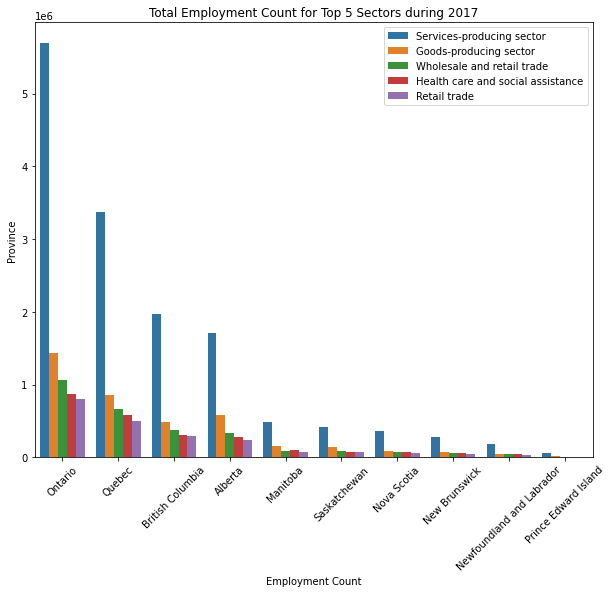

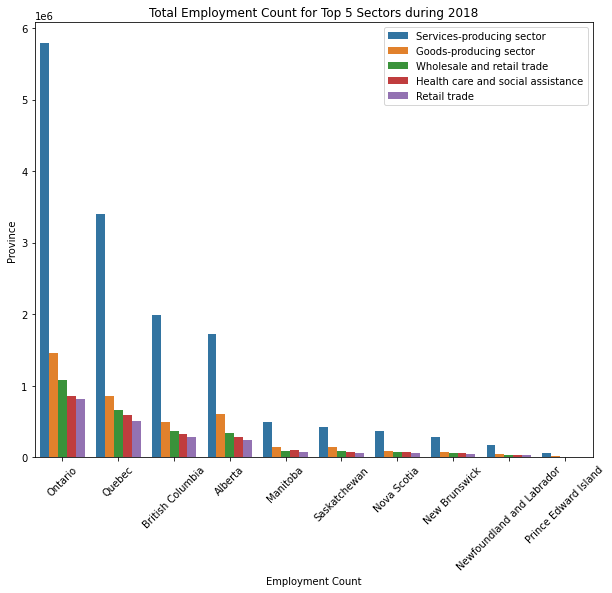

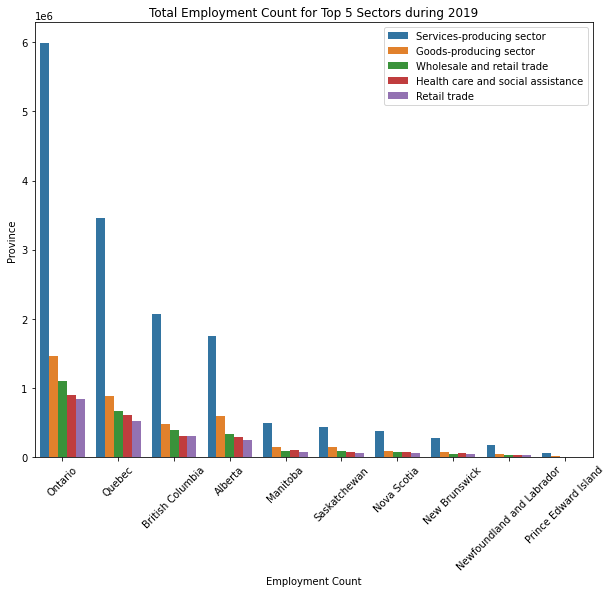

In [16]:
years = employment_data["DATE"].unique()

for i in range(0, 5):
  year_data = employment_data[employment_data["DATE"] == years[i]]
  year_data = year_data.groupby(["GEO", "NAICD"])["VALUE"].sum()
  year_top_5 = create_year_dataset(year_data, provinces)
  plt.figure(figsize=(10, 8))
  g = sns.barplot(y="value", x="province", hue="industry", data=year_top_5, ci=None)
  g.set_xticklabels(g.get_xticklabels(), rotation=45)
  plt.legend(loc="upper right")
  plt.xlabel("Employment Count")
  plt.ylabel("Province")
  plt.title("Total Employment Count for Top 5 Sectors during " + str(years[i]))  
  plt.show()


#This chunk of code genrates more compact graph but they might be difficult to read
#on smaller screens.
# fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(50, 10))
# years = employment_data["DATE"].unique()

# for i in range(0, len(years)):
#   year_data = employment_data[employment_data["DATE"] == years[i]]
#   year_data = year_data.groupby(["GEO", "NAICD"])["VALUE"].sum()
#   year_top_5 = create_year_dataset(year_data, provinces)
#   g = sns.barplot(y="value", x="province", hue="industry", data=year_top_5, ci=None, ax=axes[i])
#   g.set_xticklabels(g.get_xticklabels(), rotation=80)
#   axes[i].set_ylabel("Employment Count")
#   axes[i].set_xlabel("Province")
#   axes[i].set_title("Total Employment Count for Top 5 Sectors during " + str(years[i]))

# fig.show()

The graph above let us see that for each province the Services-producing sector has the higher employment count. At second place we can see the Goods-producing sector followed by Wholesale and retail trade, and Health care and social assistance. We can also see that Ontario has the highest employment count. For the Services-producing sector, it can be seen that the employment count has increased over the past 5 years but Quebec has continued to follow the same employment count over the past 5 years.

Now lets visualize the number of male and female workers in top 5 sector.

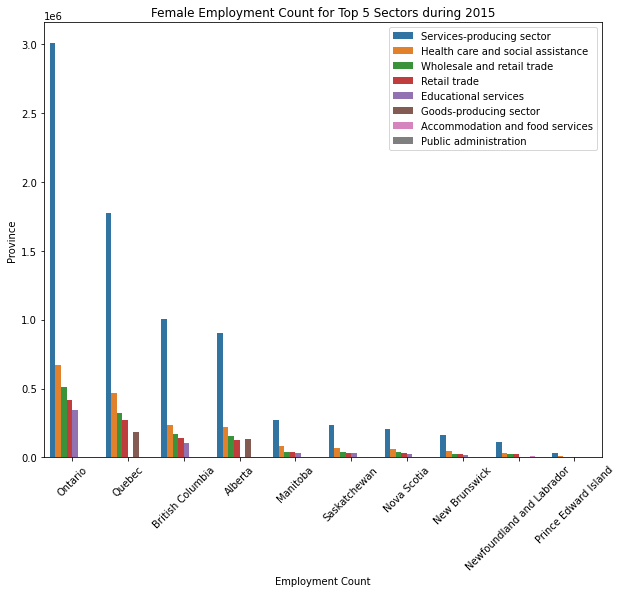

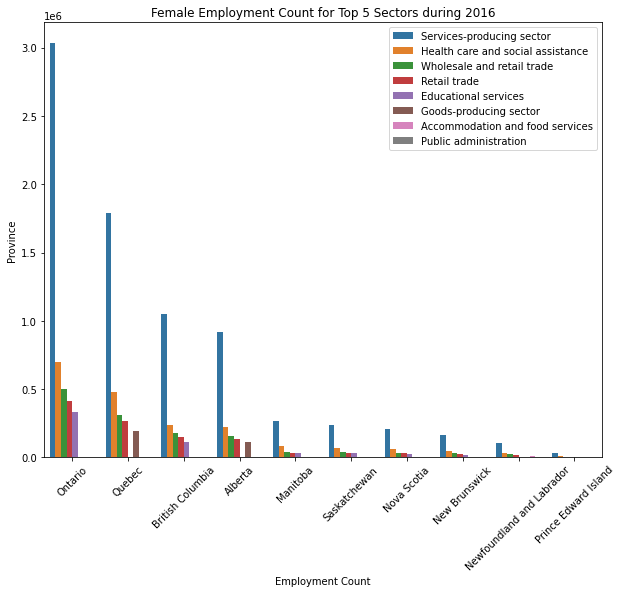

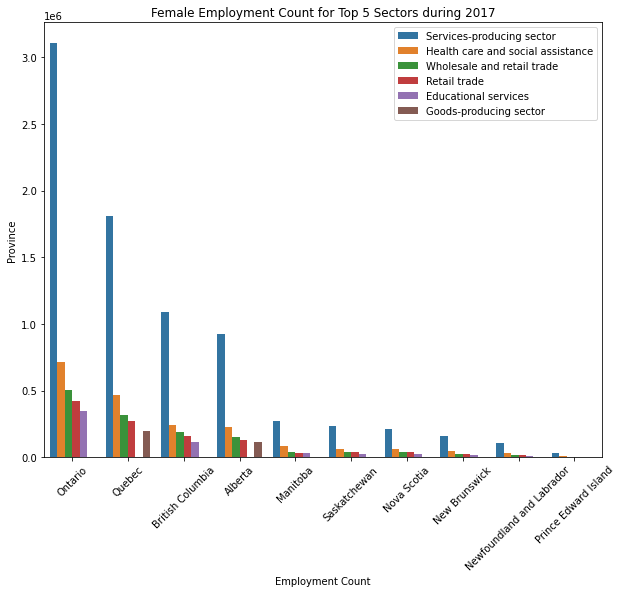

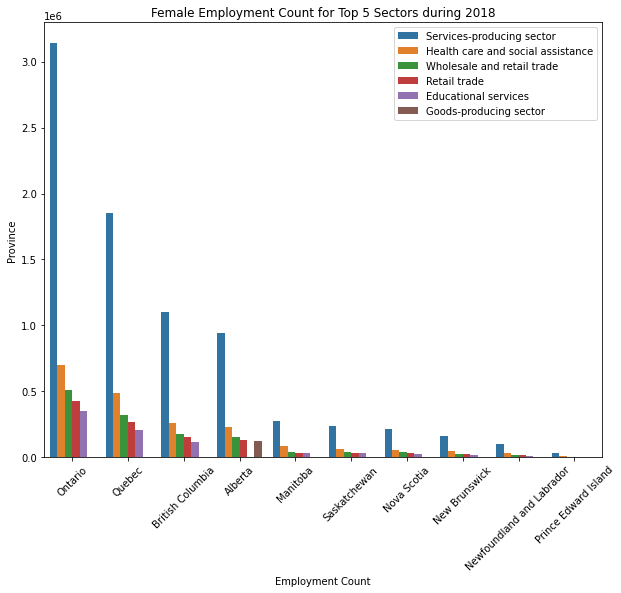

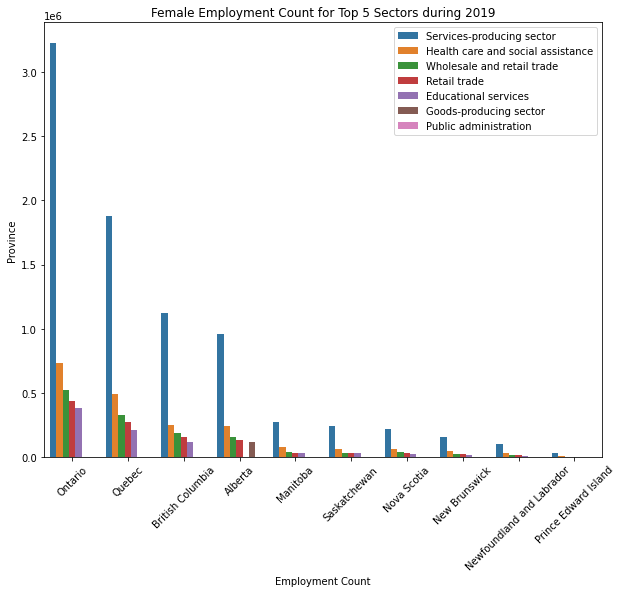

In [17]:
years = employment_data["DATE"].unique()

for i in range(0, 5):
  year_data = employment_data[(employment_data["DATE"] == years[i]) & (employment_data["Sex"] == "Females")]
  year_data = year_data.groupby(["GEO", "NAICD"])["VALUE"].sum()
  year_top_5 = create_year_dataset(year_data, provinces)
  plt.figure(figsize=(10, 8))
  g = sns.barplot(y="value", x="province", hue="industry", data=year_top_5, ci=None)
  g.set_xticklabels(g.get_xticklabels(), rotation=45)
  plt.legend(loc="upper right")
  plt.xlabel("Employment Count")
  plt.ylabel("Province")
  plt.title("Female Employment Count for Top 5 Sectors during " + str(years[i]))  
  plt.show()

#This chunk of code genrates more compact graph but they might be difficult to read
#on smaller screens.
# fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(50, 10))
# years = employment_data["DATE"].unique()

# for i in range(0, len(years)):
#   year_data = employment_data[(employment_data["DATE"] == years[i]) & (employment_data["Sex"] == "Females")]
#   year_data = year_data.groupby(["GEO", "NAICD"])["VALUE"].sum()
#   year_top_5 = create_year_dataset(year_data, provinces)
#   g = sns.barplot(y="value", x="province", hue="industry", data=year_top_5, ci=None, ax=axes[i])
#   g.set_xticklabels(g.get_xticklabels(), rotation=80)
#   axes[i].legend(loc="upper right")
#   axes[i].set_ylabel("Employment Count")
#   axes[i].set_xlabel("Province")
#   axes[i].set_title("Female Employment Count for Top 5 Sectors during " + str(years[i]))

# fig.show()

We can see that Ontario has the highest female employment count for Services-producing sector, Health care and social assistance, Wholesale and retail trade, and Retail trade. For all the provinces, the female employment count for Service-producing sector, Health care and social assistance sector, and Wholesale and retail trade sector has increased over the past 5 years.

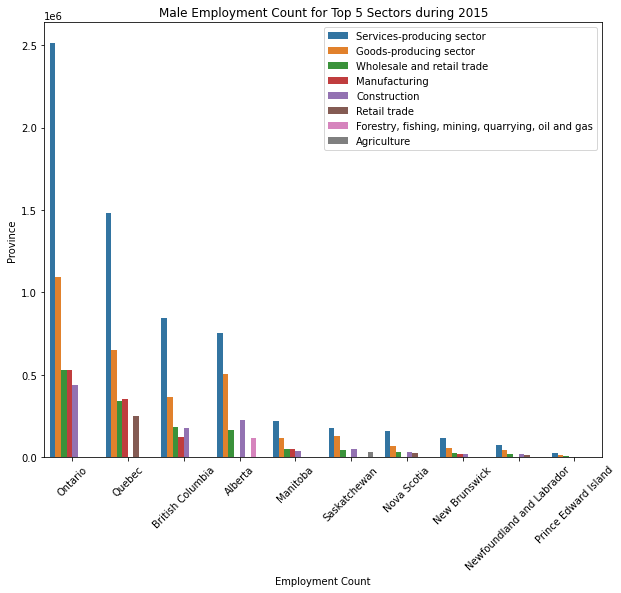

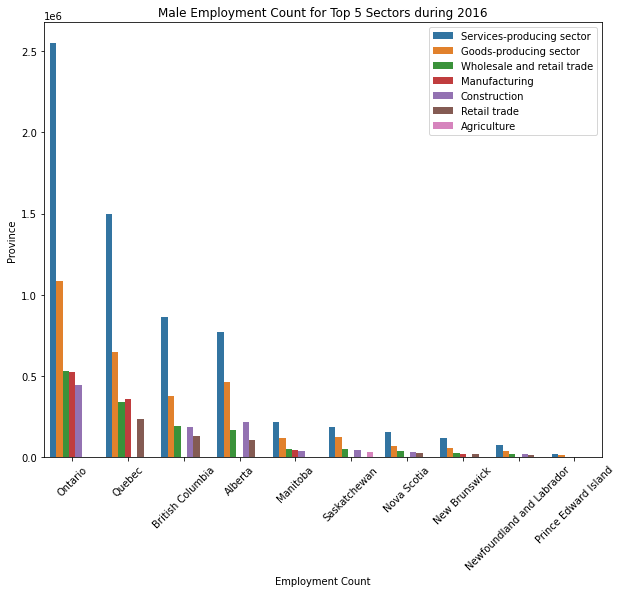

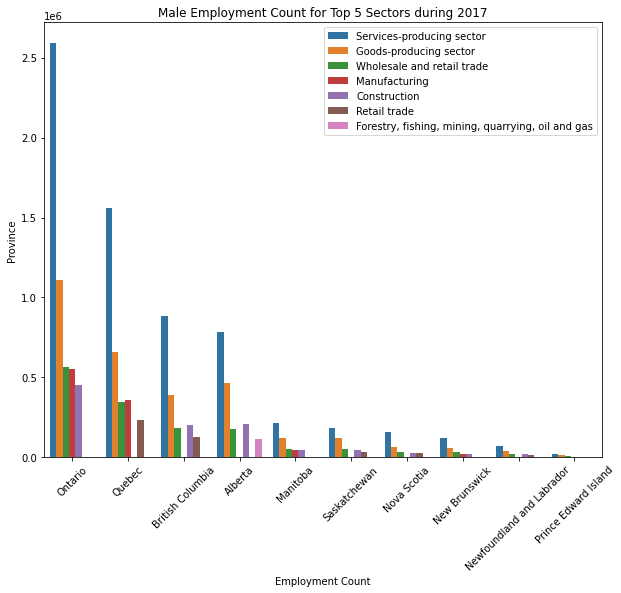

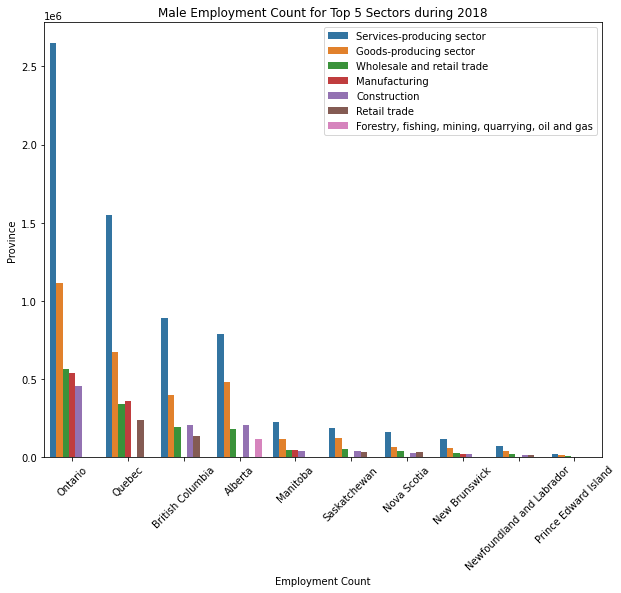

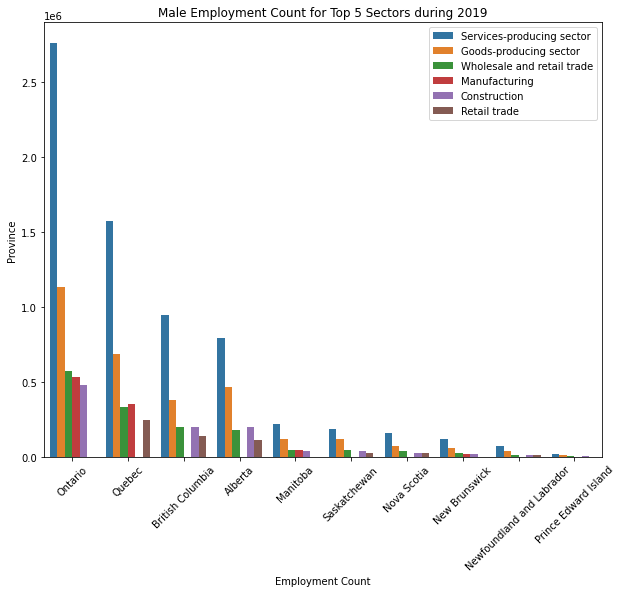

In [18]:
years = employment_data["DATE"].unique()

for i in range(0, 5):
  year_data = employment_data[(employment_data["DATE"] == years[i]) & (employment_data["Sex"] == "Males")]
  year_data = year_data.groupby(["GEO", "NAICD"])["VALUE"].sum()
  year_top_5 = create_year_dataset(year_data, provinces)
  plt.figure(figsize=(10, 8))
  g = sns.barplot(y="value", x="province", hue="industry", data=year_top_5, ci=None)
  g.set_xticklabels(g.get_xticklabels(), rotation=45)
  plt.legend(loc="upper right")
  plt.xlabel("Employment Count")
  plt.ylabel("Province")
  plt.title("Male Employment Count for Top 5 Sectors during " + str(years[i]))  
  plt.show()


#This chunk of code genrates more compact graph but they might be difficult to read
#on smaller screens.
# fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(50, 10))
# years = employment_data["DATE"].unique()

# for i in range(0, len(years)):
#   year_data = employment_data[(employment_data["DATE"] == years[i]) & (employment_data["Sex"] == "Males")]
#   year_data = year_data.groupby(["GEO", "NAICD"])["VALUE"].sum()
#   year_top_5 = create_year_dataset(year_data, provinces)
#   g = sns.barplot(y="value", x="province", hue="industry", data=year_top_5, ci=None, ax=axes[i])
#   g.set_xticklabels(g.get_xticklabels(), rotation=80)
#   axes[i].legend(loc="upper right")
#   axes[i].set_ylabel("Employment Count")
#   axes[i].set_xlabel("Province")
#   axes[i].set_title("Male Employment Count for Top 5 Sectors during " + str(years[i]))

# fig.show()


#This chunk of code generates biggers graph in a row and column fashion. Still
#these might be difficult to read on smaller screen.
# fig = plt.figure(figsize=(50, 40))
# rows = 3
# cols = 2
# years = employment_data["DATE"].unique()
# for i in range(1, 6):
#   year_data = employment_data[(employment_data["DATE"] == years[i-1]) & (employment_data["Sex"] == "Males")]
#   year_data = year_data.groupby(["GEO", "NAICD"])["VALUE"].sum()
#   year_top_5 = create_year_dataset(year_data, provinces)
#   ax = fig.add_subplot(rows, cols, i)
#   g = sns.barplot(y="value", x="province", hue="industry", data=year_top_5, ci=None, ax=ax)
#   g.set_xticklabels(g.get_xticklabels(), rotation=45)
#   ax.legend(loc="upper right")
#   ax.set_ylabel("Employment Count")
#   ax.set_xlabel("Province")
#   ax.set_title("Male Employment Count for Top 5 Sectors during " + str(years[i-1]))  
# fig.show()

From the graphs, we can see that Service-producing sector has the highest male employment count and Ontario has the most number male workers. At the second and third place, we have Goods-producing sector and Wholesale and retail tade sector. While at the fourth place, we have manufacturing sector.

Comparing the employment graphs for male and female, we can see that there are more female workers than male workers in the Health case and social assistance sector, Retail sector, and Educational sector. But there are more male workers than female workers in Good-producing sector, Manufacturing sector, and Construction sector.

Lets visualize the jobs skills dataset.

In [19]:
job_skills_data

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin..."
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...
3,Google,"Developer Advocate, Partner Engineering",Developer Relations,"Mountain View, CA, United States","Work one-on-one with the top Android, iOS, and...",BA/BS degree in Computer Science or equivalent...,"Experience as a software developer, architect,..."
4,Google,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Sunnyvale, CA, United States",Plan requirements with internal customers.\nPr...,BA/BS degree or equivalent practical experienc...,CTS Certification.\nExperience in the construc...
...,...,...,...,...,...,...,...
1245,Google,Global Investigator,Real Estate & Workplace Services,"Boulder, CO, United States",Develop protocols and practices to assess and ...,BA/BS degree or equivalent practical experienc...,Investigative or Interview certification throu...
1246,Google,Campus Security Manager,Real Estate & Workplace Services,"Boulder, CO, United States",Manage the daily operations of the security ve...,BA/BS degree or equivalent practical experienc...,Master’s degree.\nProficient in the use of com...
1247,Google,Facilities Manager,Real Estate & Workplace Services,"Xinyi District, Taiwan",Collaborate with functional teams; plan and ma...,BA/BS degree or equivalent practical experienc...,Experience managing outsourced facilities serv...
1248,Google,Physical Security Manager,Real Estate & Workplace Services,"Tel Aviv-Yafo, Israel",Partner closely with and offer guidance and co...,BA/BS degree or equivalent practical experienc...,Experience working on international programs.\...


There are 1,250 entries with 7 features. Lets see how many job postings are there for each Company.

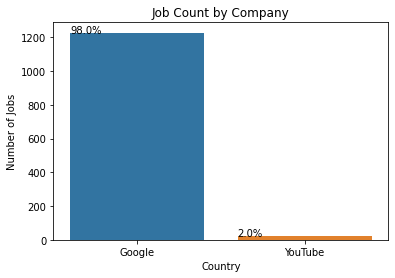

In [20]:
country_job_count = job_skills_data.groupby("Company")["Title"].count()
total_job_count = country_job_count.sum()
g = sns.barplot(x=country_job_count.index, y=country_job_count)

for p in g.patches:
  txt = str((p.get_height() / total_job_count * 100).round(0)) + "%"
  g.text(p.get_x(), p.get_height(), txt)

plt.xlabel("Country")
plt.ylabel("Number of Jobs")
plt.title("Job Count by Company")
plt.show()

The graph above tells is that the dataset only contains job posting for two companies and clearly Google has way more postings than YouTube. Google encompasses 98% of the job while YouTube only have 2% of the job postings.

Lets see how many jobs are there for each category.

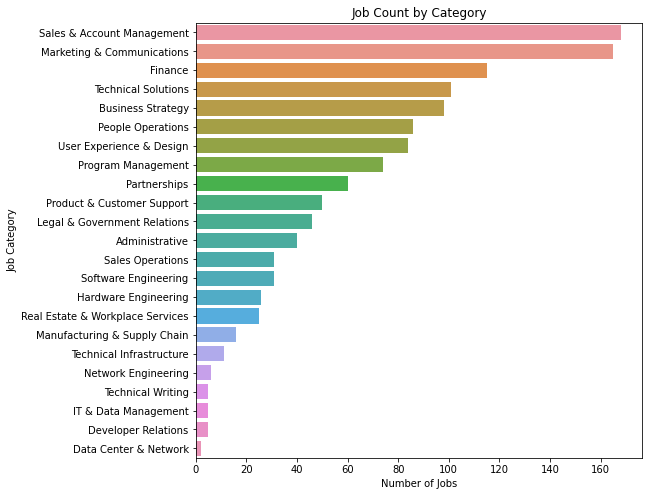

In [21]:
category_job_count = job_skills_data.groupby("Category")["Title"].count().sort_values(ascending=False)
plt.figure(figsize=(8,8))
sns.barplot(x=category_job_count, y=category_job_count.index)
plt.xlabel("Number of Jobs")
plt.ylabel("Job Category")
plt.title("Job Count by Category")
plt.show()

Looking at the graph, it looks like technical jobs have the lowest number of postings like Data Center & Network, Developer Relations and IT. The management related jobs such as Sales & Account Management, Marketing & Communications and Finance have the highest number of postings. This could indicate that jobs with higher number of postings are more in demand maybe because they are more important and companies need consistent new talent for these positions. Or, this could indicate that jobs with higher number of postings have higher drop rate meaning more people are consistently leaving these positions.

A prediction model for Employment data would be to predict future employment rates. With the current data for 5 years, the dataset might be small and would not accurately provide predictions. If the dataset size were to be increased to many years behind then it would be possible to make accurate predictions. We could use lagging window as out features which would go back 5 days or however many days we want the window to back. We could also find the trend between year and use that as a feature. 

#Title Recommendation using the job skill dataset

The idea here is to use Responsibilities for a job to generate a Title. For this I will be using NLP and LSTM to make these recommendation. Therefore, only the Title and Responsibilities column are required.

In [0]:
title_dataset = job_skills_data.drop(["Company", "Category", "Location", "Minimum Qualifications", "Preferred Qualifications"], axis=1)

Now lets clean the data, for this I will be using the NLTK toolkit.

In [60]:
title_dataset.isna().sum()

Title                0
Responsibilities    15
dtype: int64

Fill in the null or nan values with empty string.

In [0]:
title_dataset["Title"] = title_dataset["Title"].fillna("")
title_dataset["Responsibilities"] = title_dataset["Responsibilities"].fillna("")

Clean, tokenize and stem each Title and Responsibility.

In [0]:
stop_words = nltk.corpus.stopwords.words("english")
porter_stemmer = nltk.stem.PorterStemmer()

title_dataset["title_tokenized"] = title_dataset["Title"].apply(lambda x: nltk.word_tokenize(x))
title_dataset["title_tokenized"] = title_dataset["title_tokenized"].apply(lambda x: [word.strip().lower() for word in x])
title_dataset["title_tokenized"] = title_dataset["title_tokenized"].apply(lambda x: [word for word in x if word not in stop_words])
title_dataset["title_tokenized"] = title_dataset["title_tokenized"].apply(lambda sent: [token for token in sent if token not in punctuation + '‘' + '’'])
title_dataset["title_tokenized"] = title_dataset["title_tokenized"].apply(lambda sent: [token for token in sent if token not in ["''", '``', '""']])
title_dataset["title_tokenized"] = title_dataset["title_tokenized"].apply(lambda x: [porter_stemmer.stem(word) for word in x])

title_dataset["desc_tokenized"] = title_dataset["Responsibilities"].apply(lambda x: nltk.word_tokenize(x))
title_dataset["desc_tokenized"] = title_dataset["desc_tokenized"].apply(lambda x: [word.strip().lower() for word in x])
title_dataset["desc_tokenized"] = title_dataset["desc_tokenized"].apply(lambda x: [word for word in x if word not in stop_words])
title_dataset["desc_tokenized"] = title_dataset["desc_tokenized"].apply(lambda sent: [token for token in sent if token not in punctuation + '‘' + '’'])
title_dataset["desc_tokenized"] = title_dataset["desc_tokenized"].apply(lambda sent: [token for token in sent if token not in ["''", '``', '""']])
title_dataset["desc_tokenized"] = title_dataset["desc_tokenized"].apply(lambda x: [porter_stemmer.stem(word) for word in x])

Define the path for Google's word2vec

In [8]:
path = '/content/drive/My Drive/prepr challenge/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
title_dataset["title_tokenized_embed"] = title_dataset["title_tokenized"]
title_dataset["desc_tokenized_embed"] = title_dataset["desc_tokenized"]

Create the vocabulary for all the words.

In [0]:
vocabulary = {}
vocabulary_cnt = 0
inverse_vocab = {}
inverse_vocab_cnt = 0

for i, row in title_dataset.iterrows():
  # Iterate through the text of both entries of each row
  for val in ['title_tokenized', 'desc_tokenized']:

    # This array holds the value to number encode representation
    v2n = []
    for word in row[val]:
      # Check for words not in word2vec vocab
      if word not in word2vec.vocab:
        if word not in inverse_vocab:
          inverse_vocab_cnt += 1
          inverse_vocab[word] = inverse_vocab_cnt

      # If you have never seen a word, append it to vocab dictionary.
      if word not in vocabulary:
        vocabulary_cnt += 1
        vocabulary[word] = vocabulary_cnt
        v2n.append(vocabulary_cnt)
      else:
        v2n.append(vocabulary[word])

    # Replace value as word to question as number representation
    title_dataset.at[i, val + '_embed'] = v2n

Create the embedding matrix for LSTM.

In [0]:
embedding_dim = 300
# This will be the embedding matrix
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix using word2vec for LSTM embedding
for word, index in vocabulary.items():
  if word in word2vec.vocab:
    embeddings[index] = word2vec.word_vec(word)

Split the dataset into train and test. Here it will be 80% training + validation and 20% testing.

In [0]:
train, test = train_test_split(title_dataset, test_size=0.2, random_state = 42)

Find the longest title vector and embed all other vectors to have the same length by zero padding each title and description. Do the same for job descriptions.

In [0]:
max_title_seq = title_dataset['title_tokenized_embed'].map(lambda x: len(x)).max()
max_desc_seq = title_dataset['desc_tokenized_embed'].map(lambda x: len(x)).max()
#  title_dataset["title_tokenized_embed"] = tf.keras.preprocessing.sequence.pad_sequences(title_dataset["title_tokenized_embed"], maxlen=max_title_seq)

train_x = train["desc_tokenized_embed"]
test_x = test["desc_tokenized_embed"]

train_y = train["title_tokenized_embed"]
test_y = test["title_tokenized_embed"]

#do the zero padding
x_train = tf.keras.preprocessing.sequence.pad_sequences(train_x, max_desc_seq)
x_test = tf.keras.preprocessing.sequence.pad_sequences(test_x, max_desc_seq)
y_train = tf.keras.preprocessing.sequence.pad_sequences(train_y, max_title_seq)
y_test = tf.keras.preprocessing.sequence.pad_sequences(test_y, max_title_seq)

Define the LSTM neural network

In [0]:
# Model variables
n_hidden = 50
batch_size = 1024
n_epoch = 20

In [97]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(max_desc_seq, )))
model.add(tf.keras.layers.Embedding(len(embeddings), 
                                    embedding_dim, 
                                    weights=[embeddings], 
                                    input_length=max_desc_seq,
                                    trainable=False))
model.add(tf.keras.layers.LSTM(n_hidden))
model.add(tf.keras.layers.Dense(max_title_seq))
model.add(tf.keras.layers.Activation('softmax'))
model.compile(loss="categorical_crossentropy", optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 227, 300)          870300    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
_________________________________________________________________
dense (Dense)                (None, 12)                612       
_________________________________________________________________
activation (Activation)      (None, 12)                0         
Total params: 941,112
Trainable params: 70,812
Non-trainable params: 870,300
_________________________________________________________________


I am running out of time to finish this but the idea is that we train an LSTM to be able to generate title from job descriptions. The test it on the test set.
This will help the job poster to just write the job description and the model can help generate the titles.

An extension to this I would like to do is make another recommendation system using NLP in the case LSTM does not provide recommendation. The NLP technique will be more lenient and will provide more loose title recommendations. Maybe we can use TFIDF in order to make second layer recommendations.

Even if after all this the poster is not happy with the result, then they can write their own title.